<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/FLOPS/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 99% 159M/161M [00:00<00:00, 182MB/s]
100% 161M/161M [00:00<00:00, 178MB/s]


In [5]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [4]:
dataset_dir = '/content/data'

In [6]:
print(os.listdir(dataset_dir))

['Gray_Leaf_Spot', 'Common_Rust', 'Blight', 'Healthy']


In [4]:
IMAGE_SIZE_alexnet = 227

In [8]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_alexnet, IMAGE_SIZE_alexnet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [9]:
X = []
Z = []

In [10]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:06<00:00, 185.01it/s]


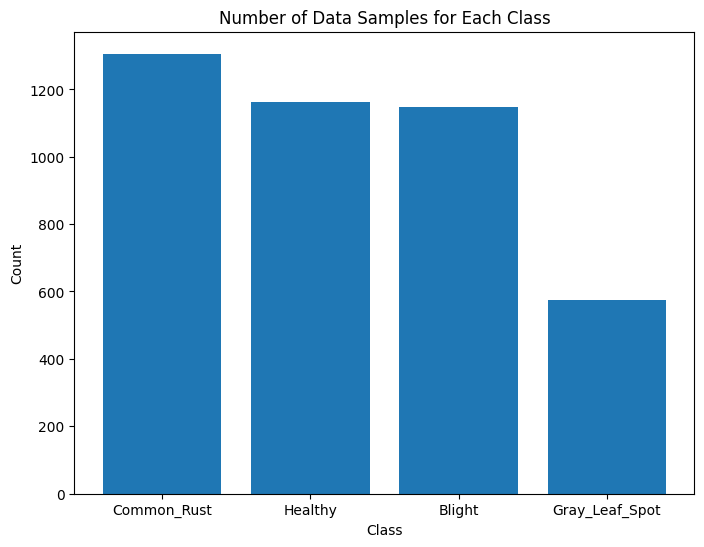

In [11]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [12]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [5]:
model_alexnet = tf.keras.models.Sequential([
        # 1st conv
        Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(IMAGE_SIZE_alexnet, IMAGE_SIZE_alexnet, 3)),
        BatchNormalization(),
        MaxPooling2D(2, strides=(2,2)),
        # 2nd conv
        Conv2D(256, (11,11), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 3rd conv
        Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 4th conv
        Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 5th Conv
        Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(2, strides=(2, 2)),
        # To Flatten layer
        Flatten(),
        # To FC layer 1
        Dense(4096, activation='relu'),
        # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
        # To FC layer 2
        Dense(4096, activation='relu'),
        # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
        Dense(4, activation='sigmoid')
    ])

#model_alexnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#model_alexnet.summary()

#history_alexnet = model_alexnet.fit(datagen.flow(X_train, Y_train), epochs=10, validation_data=(X_test, Y_test))

In [ ]:
Y_pred = model_alexnet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)

In [6]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=1):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size] + [dim for dim in model.input.shape[1:]], model.input.dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

# Calculate FLOPs
flops = get_flops(model_alexnet)
print(f"FLOPs: {flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 9450977572
